In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:

import zipfile
with zipfile.ZipFile('/content/drive/MyDrive/120dog breeds-224.zip', 'r') as zip_ref:
    zip_ref.extractall('/content/projectDataset224')

In [ ]:
import pandas as pd
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow import keras
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras import applications
from keras.layers import Activation, Dropout, Flatten, Dense,GlobalAveragePooling2D, BatchNormalization

In [ ]:
import pathlib
from keras.preprocessing.image import ImageDataGenerator


data_dir = pathlib.Path('/content/projectDataset224/120dog breeds-224')

data_train = data_dir / 'train'

test_dir = data_dir / 'test'


labels_csv = pd.read_csv('/content/drive/MyDrive/labels.csv')
labels_csv['id'] = [str(fname) + '.jpg' for fname in labels_csv['id']]

In [ ]:
batch_size = 16
img_size = 224

In [ ]:
# datagen = ImageDataGenerator(preprocessing_function = keras.applications.resnet50.preprocess_input, validation_split=0.2)
# train_generator = datagen.flow_from_dataframe(
#                         dataframe = labels_csv,
#                         directory = data_train,
#                         subset='training',
#                         x_col='id',
#                         y_col='breed',
#                         batch_size=batch_size,
#                         shuffle=True,
#                         class_mode='sparse',
#                         color_mode='rgb',
#                         target_size=(img_size, img_size))

# validation_generator = datagen.flow_from_dataframe(
#                         dataframe = labels_csv,
#                         directory = data_train,
#                         subset='validation',
#                         x_col='id', 
#                         y_col='breed',
#                         batch_size=batch_size,
#                         shuffle=True,
#                         class_mode='sparse',
#                         color_mode='rgb',
#                         target_size=(img_size, img_size))


train_datagen = ImageDataGenerator(
    preprocessing_function=keras.applications.resnet50.preprocess_input,
    validation_split=0.2,
    rotation_range=5,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1,
    shear_range=0.05,
    brightness_range=[0.8, 1.2],
    horizontal_flip=True
)


train_generator = train_datagen.flow_from_dataframe(
    dataframe=labels_csv,
    directory=data_train,
    subset='training',
    x_col='id',
    y_col='breed',
    batch_size=batch_size,
    shuffle=True,
    # class_mode='sparse',
    class_mode='categorical',
    color_mode='rgb',
    target_size=(img_size, img_size)
)

validation_datagen = ImageDataGenerator(
    preprocessing_function = keras.applications.resnet50.preprocess_input, 
    validation_split=0.2
)

validation_generator = validation_datagen.flow_from_dataframe(
    dataframe=labels_csv,
    directory=data_train,
    subset='validation',
    x_col='id',
    y_col='breed',
    batch_size=batch_size,
    shuffle=True,
    # class_mode='sparse',
    class_mode='categorical',
    color_mode='rgb',
    target_size=(img_size, img_size)
)


from keras.utils import to_categorical
train_labels = to_categorical(train_generator.labels)
validation_labels = to_categorical(validation_generator.labels)

Found 8178 validated image filenames belonging to 120 classes.
Found 2044 validated image filenames belonging to 120 classes.


In [ ]:
import tensorflow as tf
from tensorflow.python.keras.metrics import AUC
from sklearn.metrics import roc_curve, auc

# Define the ROC metrics
tpr = tf.keras.metrics.TruePositives(name='tp')
fpr = tf.keras.metrics.FalsePositives(name='fp')
auc_metric = AUC(name='auc')

In [ ]:
resnet50 = keras.applications.ResNet50(include_top=False, weights='imagenet',input_shape=(224,224,3))

for layer in resnet50.layers:
    layer.trainable=False

model = Sequential()
model.add(resnet50)
model.add(BatchNormalization())
model.add(GlobalAveragePooling2D())
model.add(Dropout(0.5))
model.add(Dense(2048, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(120, activation='softmax'))
model.summary()

optimizer=tf.keras.optimizers.Adam(learning_rate = 0.0001)
model.compile(optimizer=optimizer,
              # loss='sparse_categorical_crossentropy',
              loss='categorical_crossentropy',
              metrics=[tpr, fpr, auc_metric, 'accuracy', 'Precision', 'Recall'])
              # metrics=['accuracy'])

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 batch_normalization_1 (Batc  (None, 7, 7, 2048)       8192      
 hNormalization)                                                 
                                                                 
 global_average_pooling2d_1   (None, 2048)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dropout_2 (Dropout)         (None, 2048)              0         
                                                                 
 dense_2 (Dense)             (None, 2048)              4196352   
                                                                 
 dropout_3 (Dropout)         (None, 2048)             

In [ ]:
# optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)
# model.compile(optimizer=optimizer,
#               loss='sparse_categorical_crossentropy',
#               metrics=['accuracy'])

In [ ]:
# history_res = model.fit(train_generator, epochs=50, verbose = 1,
#                        validation_data=validation_generator)

from keras.callbacks import ModelCheckpoint, EarlyStopping


checkpoint_cb = ModelCheckpoint("/content/drive/MyDrive/Resnet50-Epoch50DataAugmentationHighROCVersion3.h5", save_best_only=True)
# checkpoint_cb = ModelCheckpoint("/content/drive/MyDrive/Resnet50-Epoch50_New120breedsVersion6.h5", save_best_only=True)

early_stopping_cb = EarlyStopping(patience=5, restore_best_weights=True)


history_res = model.fit(train_generator, epochs=50, verbose = 1,
                        validation_data=validation_generator,
                        callbacks=[checkpoint_cb, early_stopping_cb])

Epoch 1/50
512/512 [==============================] - 158s 297ms/step - loss: 3.7022 - tp: 43.0000 - fp: 2.0000 - auc: 0.7155 - accuracy: 0.2414 - precision: 0.9556 - recall: 0.0053 - val_loss: 2.1268 - val_tp: 150.0000 - val_fp: 8.0000 - val_auc: 0.8620 - val_accuracy: 0.6238 - val_precision: 0.9494 - val_recall: 0.0734
Epoch 2/50
512/512 [==============================] - 145s 283ms/step - loss: 1.9752 - tp: 1220.0000 - fp: 130.0000 - auc: 0.9085 - accuracy: 0.5632 - precision: 0.9037 - recall: 0.1492 - val_loss: 1.1984 - val_tp: 822.0000 - val_fp: 79.0000 - val_auc: 0.9348 - val_accuracy: 0.7074 - val_precision: 0.9123 - val_recall: 0.4022
Epoch 3/50
512/512 [==============================] - 141s 276ms/step - loss: 1.3487 - tp: 3111.0000 - fp: 386.0000 - auc: 0.9489 - accuracy: 0.6630 - precision: 0.8896 - recall: 0.3804 - val_loss: 0.9514 - val_tp: 1143.0000 - val_fp: 156.0000 - val_auc: 0.9584 - val_accuracy: 0.7368 - val_precision: 0.8799 - val_recall: 0.5592
Epoch 4/50
512/512 

In [ ]:
# model.save('/content/drive/MyDrive/Resnet50-Epoch50_Version6_New120breeds.h5')

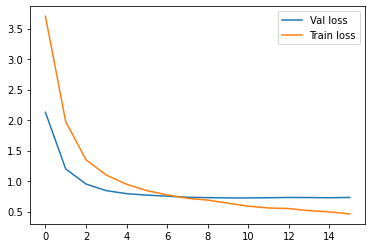

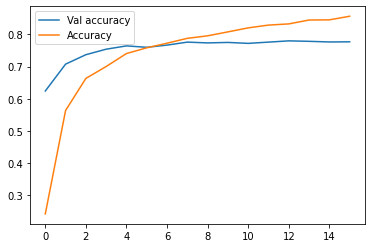

In [ ]:
plt.figure()
plt.plot(history_res .history['val_loss'], label = 'Val loss')
plt.plot(history_res .history['loss'], label = 'Train loss')
plt.legend()
plt.show()
plt.figure()
plt.plot(history_res .history['val_accuracy'], label = 'Val accuracy')
plt.plot(history_res .history['accuracy'], label = 'Accuracy')
plt.legend()
plt.show()

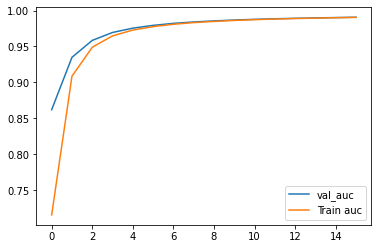

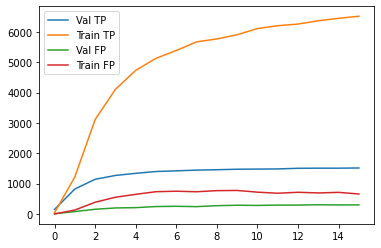

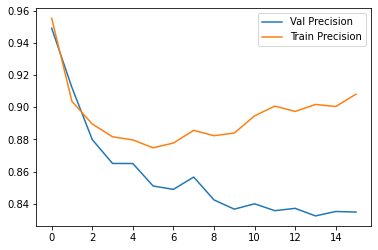

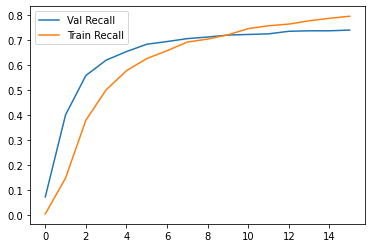

In [ ]:
plt.figure()
plt.plot(history_res .history['val_auc'], label = 'val_auc')
plt.plot(history_res .history['auc'], label = 'Train auc')
plt.legend()
plt.show()

plt.figure()
plt.plot(history_res .history['val_tp'], label = 'Val TP')
plt.plot(history_res .history['tp'], label = 'Train TP')
plt.plot(history_res .history['val_fp'], label = 'Val FP')
plt.plot(history_res .history['fp'], label = 'Train FP')
plt.legend()
plt.show()

plt.figure()
plt.plot(history_res .history['val_precision'], label = 'Val Precision')
plt.plot(history_res .history['precision'], label = 'Train Precision')
plt.legend()
plt.show()

plt.figure()
plt.plot(history_res .history['val_recall'], label = 'Val Recall')
plt.plot(history_res .history['recall'], label = 'Train Recall')
plt.legend()
plt.show()

